## Libraries and Data 

In [2]:
# Import libraries
import numpy as np
import pandas as pd
from prophet import Prophet
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import cross_validation
from prophet.utilities import regressor_coefficients
import matplotlib.pyplot as plt

In [38]:
# Import data
df = pd.read_csv('Rainfall_data.csv')
df.head()

,Year,Month,Day,Specific Humidity,Relative Humidity,Temperature,Precipitation
0,2000,1,1,8.06,48.25,23.93,0.00
1,2000,2,1,8.73,50.81,25.83,0.11
2,2000,3,1,8.48,42.88,26.68,0.01
3,2000,4,1,13.79,55.69,22.49,0.02
4,2000,5,1,17.40,70.88,19.07,271.14


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Year               252 non-null    int64  
 1   Month              252 non-null    int64  
 2   Day                252 non-null    int64  
 3   Specific Humidity  252 non-null    float64
 4   Relative Humidity  252 non-null    float64
 5   Temperature        252 non-null    float64
 6   Precipitation      252 non-null    float64
dtypes: float64(4), int64(3)
memory usage: 13.9 KB


In [39]:
df['ds'] = pd.to_datetime(df[['Year', 'Month', 'Day']])
df = df.drop(columns=['Year', 'Month', 'Day'])
#df.index = df['ds']
df.head()

,Specific Humidity,Relative Humidity,Temperature,Precipitation,ds
0,8.06,48.25,23.93,0.00,2000-01-01
1,8.73,50.81,25.83,0.11,2000-02-01
2,8.48,42.88,26.68,0.01,2000-03-01
3,13.79,55.69,22.49,0.02,2000-04-01
4,17.40,70.88,19.07,271.14,2000-05-01


In [16]:
df.describe()

,Specific Humidity,Relative Humidity,Temperature,Precipitation
count,252.000000,252.000000,252.000000,252.000000
mean,14.416746,67.259524,16.317262,206.798929
std,4.382599,17.307101,6.584842,318.093091
min,5.740000,34.690000,4.730000,0.000000
25%,10.010000,51.845000,10.865000,0.402500
50%,15.200000,66.655000,16.915000,11.495000
75%,18.875000,84.610000,22.115000,353.200000
max,20.570000,92.310000,29.340000,1307.430000


<AxesSubplot:xlabel='ds'>

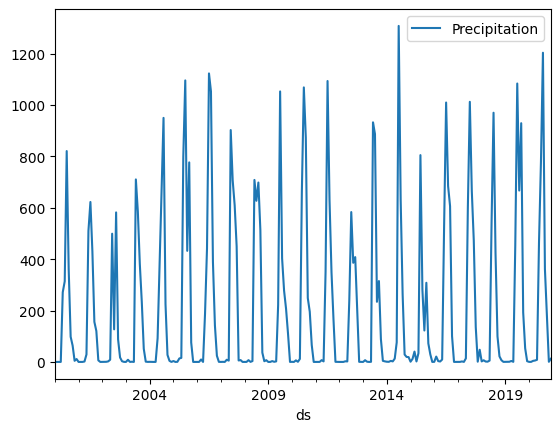

In [24]:
rain = pd.DataFrame(df['Precipitation'])
rain.index.freq = 'MS'
rain.plot()

# No Holidays So we'll skip to the model itself then

In [26]:
df = df.rename(columns={'Precipitation': 'y'})
df.head(0)

,Specific Humidity,Relative Humidity,Temperature,y,ds
ds,,,,,


In [27]:
# Test and training sets
test_months = 6
training = df.iloc[:-test_months, :]
test = df.iloc[-test_months:, :]
print(training.tail(1))
print(test.head(1))

            Specific Humidity  Relative Humidity  ...       y         ds
ds                                                ...                   
2020-06-01              19.78               83.0  ...  462.71 2020-06-01

[1 rows x 5 columns]
            Specific Humidity  Relative Humidity  ...       y         ds
ds                                                ...                   
2020-07-01              20.26              90.19  ...  781.13 2020-07-01

[1 rows x 5 columns]


In [43]:
m = Prophet(growth='linear',
            yearly_seasonality=True,
            weekly_seasonality=False,
            holidays=None,
            seasonality_mode='additive',
            seasonality_prior_scale=10,
            holidays_prior_scale=10,
            changepoint_prior_scale=.05)
m.add_regressor('Specific Humidity')
m.add_regressor('Relative Humidity')
m.add_regressor('Temperature', mode='multiplicative')
m.fit(training)


18:51:47 - cmdstanpy - INFO - Chain [1] start processing
18:51:47 - cmdstanpy - INFO - Chain [1] done processing


In [40]:
future = m.make_future_dataframe(periods=test_months, freq='M')

future = pd.concat([future, df.iloc[:,0:3]], axis=1)
future.head()

,ds,Specific Humidity,Relative Humidity,Temperature
0,2000-01-01,8.06,48.25,23.93
1,2000-02-01,8.73,50.81,25.83
2,2000-03-01,8.48,42.88,26.68
3,2000-04-01,13.79,55.69,22.49
4,2000-05-01,17.40,70.88,19.07


In [44]:
forecast = m.predict(future)
forecast.columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'Relative Humidity', 'Relative Humidity_lower',
       'Relative Humidity_upper', 'Specific Humidity',
       'Specific Humidity_lower', 'Specific Humidity_upper', 'Temperature',
       'Temperature_lower', 'Temperature_upper', 'additive_terms',
       'additive_terms_lower', 'additive_terms_upper',
       'extra_regressors_additive', 'extra_regressors_additive_lower',
       'extra_regressors_additive_upper', 'extra_regressors_multiplicative',
       'extra_regressors_multiplicative_lower',
       'extra_regressors_multiplicative_upper', 'multiplicative_terms',
       'multiplicative_terms_lower', 'multiplicative_terms_upper', 'yearly',
       'yearly_lower', 'yearly_upper', 'yhat'],
      dtype='object')

In [45]:
# Coeffecient Regressors
regressor_coefficients(m)

,regressor,regressor_mode,center,coef_lower,coef,coef_upper
0,Specific Humidity,additive,14.339431,-10.137405,-10.137405,-10.137405
1,Relative Humidity,additive,66.864431,8.405058,8.405058,8.405058
2,Temperature,multiplicative,16.434837,-0.018727,-0.018727,-0.018727


In [47]:
# Assesment
preds = forecast.yhat[-test_months:]



In [48]:
# Accuracy Assesment
from sklearn.metrics import mean_squared_error, mean_absolute_error
print(mean_absolute_error(test.y, preds))
print(np.sqrt(mean_squared_error(test.y, preds)))

155.4935735093417
259.7064092962932


# Visualization

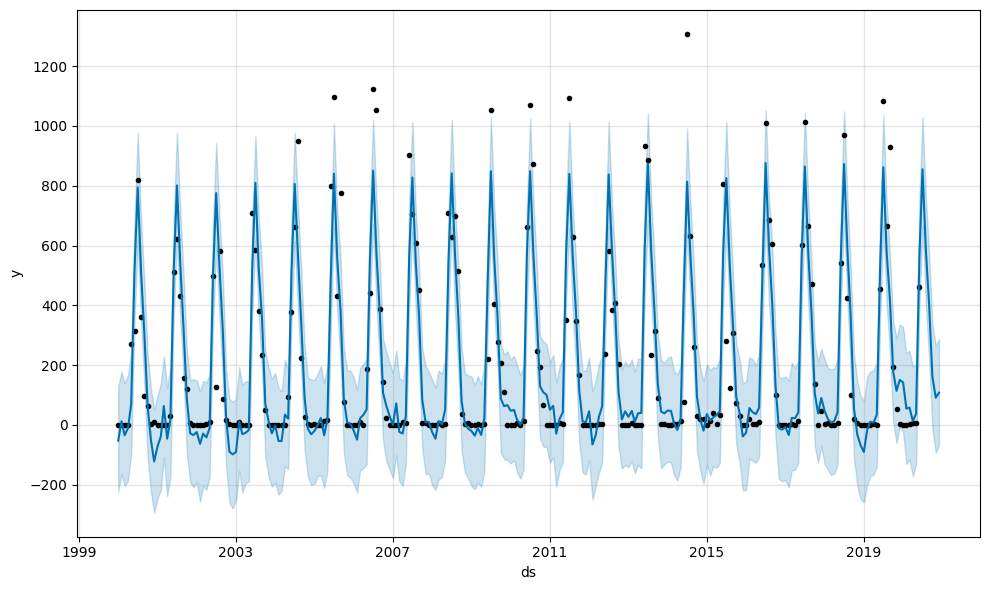

In [49]:
m.plot(forecast);

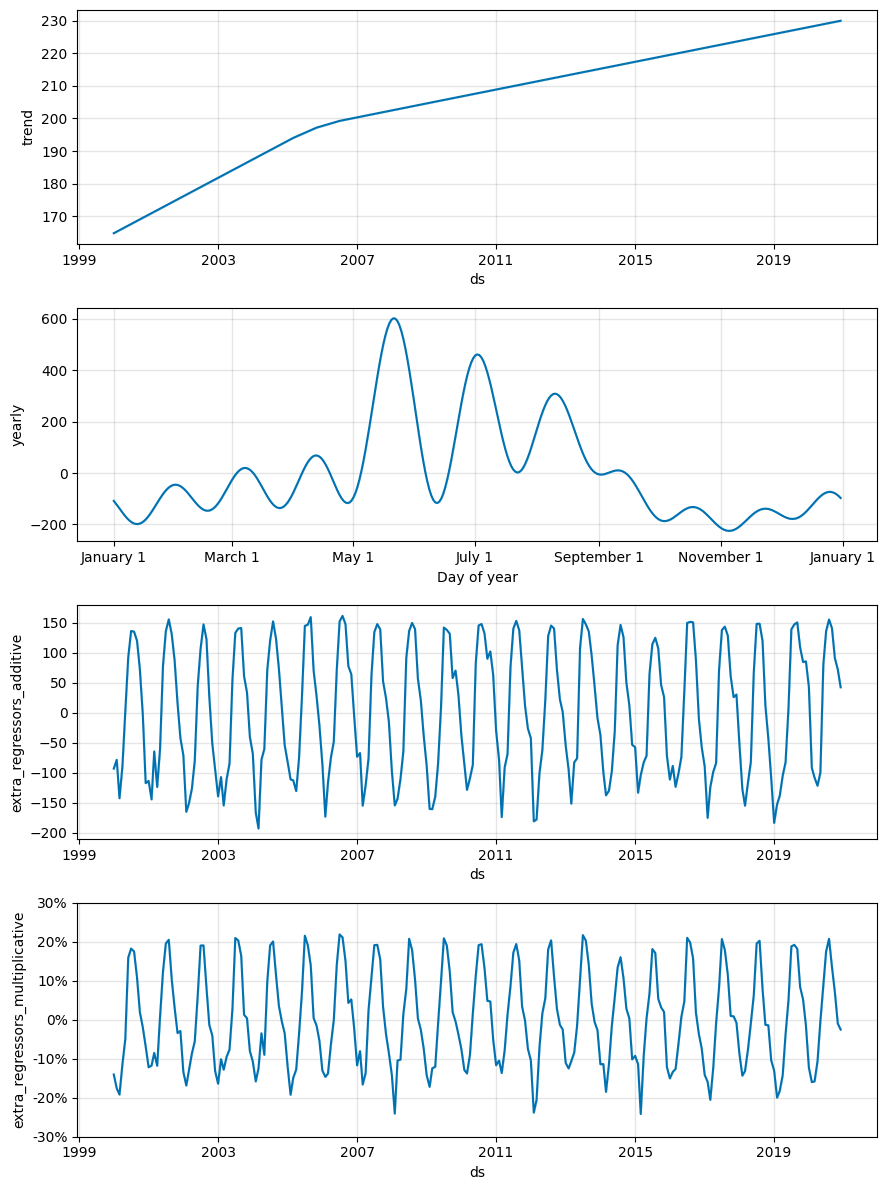

In [51]:
m.plot_components(forecast);

# Cross validation loop


In [57]:
# cv

df_cv = cross_validation(m, horizon='180 days', initial='540 days', parallel='processes')

df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2001-10-01,269.190128,269.190123,269.190133,120.24,2001-09-09
1,2001-11-01,48.427157,48.427142,48.427169,6.15,2001-09-09
2,2001-12-01,105.469113,105.469085,105.469142,0.00,2001-09-09
3,2002-01-01,297.579525,297.579491,297.579559,0.03,2001-09-09
4,2002-02-01,-304.432785,-304.432827,-304.432743,0.11,2001-09-09


In [58]:
# Assess this now
print(mean_absolute_error(df_cv.y, df_cv['yhat']))
print(np.sqrt(mean_squared_error(df_cv.y, df_cv['yhat'])))

114.24069931277026
169.39632448858765


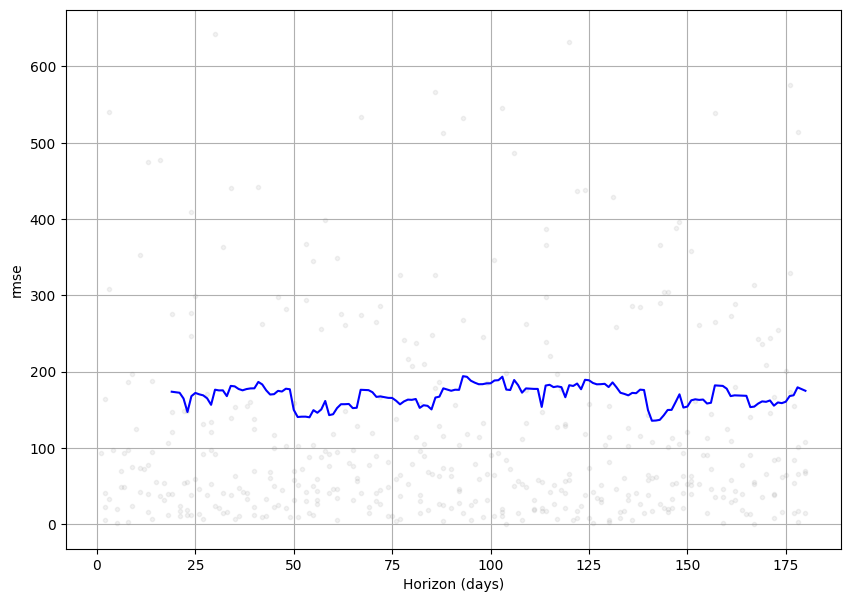

In [61]:
# Visualize
plot_cross_validation_metric(df_cv, metric='rmse', figsize=(10,7));